# Vivarium overview

**Overview:**  This notebook walks through the Vivarium terminology by building a simple, qualitative example of transcription/translation.


In [1]:
# import the Process and Composite base classes
from vivarium.core.process import (
    Process, 
    Deriver,
    Composite)

# helper functions for composition
from vivarium.core.composition import (
    simulate_process_in_experiment,
    simulate_compartment_in_experiment,
    compartment_in_experiment,
    compose_experiment,
    GENERATORS_KEY)

# other vivarium imports
from vivarium.core.experiment import Experiment, pp
from vivarium.library.units import units

# plotting functions
from vivarium.plots.simulation_output import plot_simulation_output
from vivarium.plots.agents_multigen import plot_agents_multigen
from vivarium.plots.topology import plot_compartment_topology

# other imports
import pylab as plt
import numpy as np

# suppress warnings
import warnings
warnings.filterwarnings('ignore')
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [2]:
# simple plot function
var_colors = {
    'G': 'blue',
    'C': 'orange',
    'X': 'green'}

def plot_output(output):
    fig = plt.figure(figsize=(8, 5))
    time_vec = output['time']
    for port, variables in output.items():
        if isinstance(variables, dict):
            for var, series in variables.items(): 
                color = var_colors.get(var)
                plt.plot(
                    time_vec, 
                    series, 
                    color=color, 
                    label=(port, var))
    plt.xlabel('time (sec)')
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


# 1. Make a Process or two
**Processes** are the basic building blocks of Vivarium. A Process simulates (models) one physical process such as DNA translation or protein decay. It can implement any kind of dynamical model: dynamic flux balance analysis, differential equation, stochastic process, Boolean logic, etc.

**Processes** save all their state variables in Data **Stores**. Processes connect to the Stores via **Ports**.

Each Process is implemented as a Python class with this protocol:
1. `__init__()` (the *constructor*) accepts modeling parameters and configures the Processes.
2. `ports_schema()` returns the Processes' Port schema definitions which tell Vivarium how to set up its state variables in Stores.
3. `next_update()` runs the model for a timestep and returns a message to update its state variables.


## Example: A DNA -> RNA Transcription Process

* $G \xrightarrow[]{k_{tx}} G + C $ 
* $C \xrightarrow[]{k_{deg}} \emptyset$

_\[TODO: Name these terms and explain the arrows and empty set for a general audience. How does this formula change C but not G, and yet it looks like C goes to nothing? How do these equations lead to the dC expression?\]_


### Modeling Parameters
* This Process class' `defaults` attribute defines its modeling parameters `ktx` and `kdeg` with their default values.

### Constructor
* The constructor's `parameters` arguments will override the default modeling parameters. The following example class defines a constructor to show `parameters` handling, but it's not actually needed since the inherited Process constructor would handle the parameters and this Process has nothing else to initialize.

### Ports Schema Method
* One Port for `DNA`, storing the state variable `G`. The schema provides a default value, implying its data type, and optional attributes like `_updater` and `_emit`.
* One Port for `mRNA`, storing the state variable `C`.
 
_\[TODO: Why have two Stores in this example? Is it a better design to separate DNA and mRNA data? Is it to make separate scopes for the state variable names? To be able to wire just one of these Stores (rather than just one of the state variables) to the Translation Process?\]_  
_\[TODO: Are the `_default` values the initial values?\]_  

### Update Method
* Retrieve the state variables from the Stores' `states` message.
* Run the model for the timestep’s duration.
* Return the state variable updates.

In [31]:
class Transcription(Process):

    defaults = {
        'ktx': 5e-2,
        'kdeg': 1e-2}

    def ports_schema(self):
        return {
            'DNA': {  # This Process's 'DNA' Port contains one variable, named 'G'
                'G': {
                    '_default': 1,             # default value
                    '_updater': 'accumulate',  # treat update values as deltas and accumulate (sum) them
                    '_emit': True}},           # emit the sequence of values to a simulation log DB
            'mRNA': {
                'C': {
                    '_default': 1,
                    '_updater': 'accumulate',
                    '_emit': True}}}

    def next_update(self, timestep, states):
        # Retrieve the state variables
        G = states['DNA']['G']
        C = states['mRNA']['C']

        # Run the model for the timestep duration
        dC = (self.parameters['ktx'] * G - self.parameters['kdeg'] * C) * timestep

        # Return the state variable updates: in this case, an incremental update to one variable
        return {
            'mRNA': {
                'C': dC}}
    

## Run the Transcription Process on its own


Experiment ID: 33804d2a-4642-11eb-9431-acde48001122
Created: 12/24/2020 at 15:46:11
Completed in 0.045214 seconds


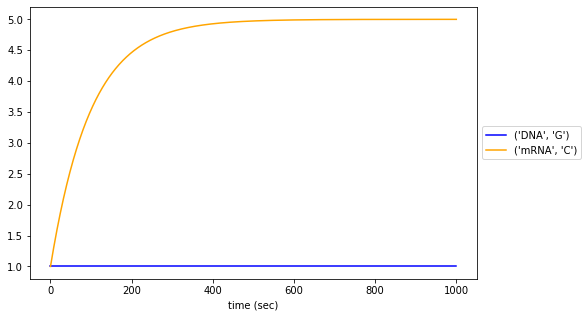

In [4]:
# construct a Transcription Process
transcription_process = Transcription()

# run it via the helper function simulate_process_in_experiment()
sim_settings = {
    'total_time': 1000,
    'experiment_id': 'Tx'}
transcription_output = simulate_process_in_experiment(
    transcription_process, 
    sim_settings)

# plot the output
plot_output(transcription_output)


## Example: An mRNA -> Protein Translation Process

* $C \xrightarrow[]{k_{tl}} C + X $ 
* $X \xrightarrow[]{k_{deg}} \emptyset$


### Modeling Parameters
* This Process class defines its modeling parameters `ktl` and `kdeg` with their default values.

### Constructor
* This class just uses its inherited `Process` constructor.

### Ports Schema Method
* One Port for `mRNA` and one port for `Protein`s, each storing a single state variable. This example doesn't specify their `_updater` methods because in fact the default updater is `accumulate`. It specifies their `_divider` methods which control what happens to the state values when a cell divides into two daughter cells.

### Update Method
* Retrieve the state variables from the Stores' `states` message.
* Run the model for the timestep’s duration.
* Return the state variable updates.

In [5]:
class Translation(Process):

    defaults = {
        'ktl': 1e-1,
        'kdeg': 1e-3}

    def ports_schema(self):
        return {
            'mRNA': {
                'C': {
                    '_default': 1.0,
                    '_divider': 'split',
                    '_emit': True}},
            'Protein': {
                'X': {
                    '_default': 1.0,
                    '_divider': 'split',
                    '_emit': True}}}

    def next_update(self, timestep, states):
        C = states['mRNA']['C']
        X = states['Protein']['X']
        dX = (self.parameters['ktl'] * C - self.parameters['kdeg'] * X) * timestep
        return {
            'Protein': {
                'X': dX}}
    

## Run the Translation Process on its own


Experiment ID: 33a83eca-4642-11eb-9431-acde48001122
Created: 12/24/2020 at 15:46:11
Completed in 0.043593 seconds


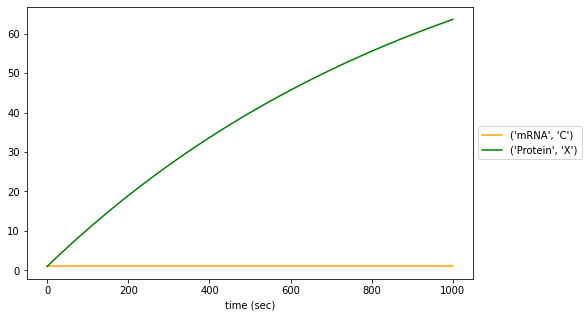

In [6]:
# construct a Translation Process
translation_process = Translation()

# run it via the helper function simulate_process_in_experiment()
sim_settings = {
    'total_time': 1000,
    'experiment_id': 'Tl'}
translation_output = simulate_process_in_experiment(
    translation_process, 
    sim_settings)

# plot the output
plot_output(translation_output)


# 2. Make a Composite

A **Composite** is a network of Processes and data Stores. Vivarium constructs the Stores from the Processes's Port Schemas and wires them up per the Composite's **Topology** definition. The only communication between Vivarium Processes is via state variables in shared Stores.

Each Composite is implemented as a Python class with this protocol:
1. `generate_processes()` constructs the Processes, passing in modeling parameters as needed, and returns them in a dictionary which names each Process instance.
2. `generate_topology()` returns the Topology definition which tells Vivarium how to wire up the Processes to Stores.

## Example “TxTl”: A Transcription + Translation Composite

This Composite combines our `Transcription` and `Translation` Processes along with 3 Stores.

* `generate_processes()` constructs a `Transcription` Process `'Tx'` and a `Translation` Process `'Tl'`.
* `generate_topology()` returns the Topology definition that wires these Processes together with 3 Stores, one of them shared.

_\[TODO: What happens if the Topology doesn't list all the Process's stores?\]_

<img src="composite.svg" alt="Composite" style="width:300px;"/>

In [30]:
# NOTE: This is an oversimplified example. Don't use it for modeling.

class TxTl(Composite):
    
    def generate_processes(self, config):
        return {
            'Tx': Transcription(),
            'Tl': Translation()}

    def generate_topology(self, config):
        return {
            'Tx': {
                'DNA': ('DNA',),    # connect the Tx Process's 'DNA' Port to the 'DNA' Store
                'mRNA': ('mRNA',),  # connect the Tx Process's 'mRNA' Port to the 'mRNA' Store
            },
            'Tl': {
                'mRNA': ('mRNA',),  # connect the Tl Process's 'mRNA' Port to the same 'mRNA' Store
                'Protein': ('Protein',),
            },
        }
    

## Run the TxTl Composite


Experiment ID: TxTl
Created: 12/24/2020 at 15:47:47
Completed in 0.090142 seconds


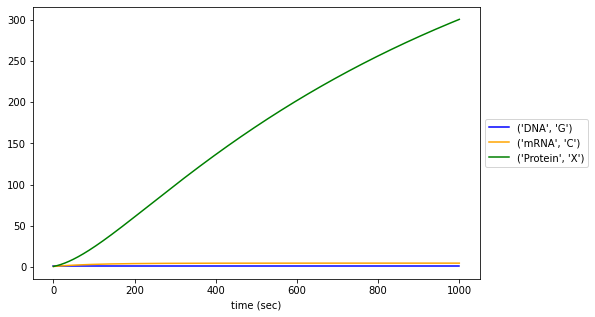

In [19]:
# construct a TxTl composite
tx_tl_composite = TxTl()

# make the experiment
exp_settings = {
    'experiment_id': 'TxTl'}
tx_tl_experiment = compartment_in_experiment(
    tx_tl_composite, 
    exp_settings)

# run it and retrieve the data that was emitted to the simulation log
tx_tl_experiment.update(1000)
tx_tl_data = tx_tl_experiment.emitter.get_timeseries()

# plot the output
plot_output(tx_tl_data)


# Make Stochastic Transcription Process

This process uses a simple Gillespie function in its update.

In [9]:
# a simple Gillespie function
def gillespie(X, dT, ktx, kdeg):
    # X: initial condition
    # dT: how long to simulate
    # ktx: transcription rate
    # kdeg: degradation rate
    stoichiometry = np.array([[0, 1], [0, -1]])
    
    t = 0
    while t < dT:
        # Calculate propensities
        propensities = [ktx*X[0], kdeg*X[1]]
        prop_sum = sum(propensities)

        # Wait time is distributed exponentially
        wait_time = np.random.exponential(scale = prop_sum)

        # We haven't hit the end of the simulation
        if wait_time + t < dT:
            t += wait_time

            # choose next reaction
            r_rxn = np.random.random()
            for i in range(len(propensities)):
                if r_rxn < propensities[i]/prop_sum:
                    # This means propensity i fires
                    break
            X += stoichiometry[i]

        else: # We have hit the end of the simulation
            return X


# Stochastic Transcription Process, which uses Gillespie in its update
class StochasticTranscription(Process):

    defaults = {
        'ktx': 1e-2,
        'kdeg': 1e-2}
        
    def ports_schema(self):
        return {
            'DNA': {
                'G': {
                    '_default': 1.0,
                    '_emit': True}},
            'mRNA': {
                'C': {
                    '_default': 1.0,
                    '_emit': True}}}
    
    def next_update(self, timestep, states):
        
        # retrieve the states
        G = states['DNA']['G']
        C = states['mRNA']['C']
        
        # apply the mechanism
        state = np.array([G, C])
        new_state = gillespie(
            state, 
            timestep,
            self.parameters['ktx'], 
            self.parameters['kdeg'])
        
        # get delta mRNA
        C1 = new_state[1]
        dC = C1 - C
        
        # return an update
        return {
            'mRNA': {
                'C': dC}}


# Simulate Stochastic Transcription Process


Experiment ID: stochastic_tx
Created: 12/24/2020 at 15:48:17
Completed in 0.009920 seconds


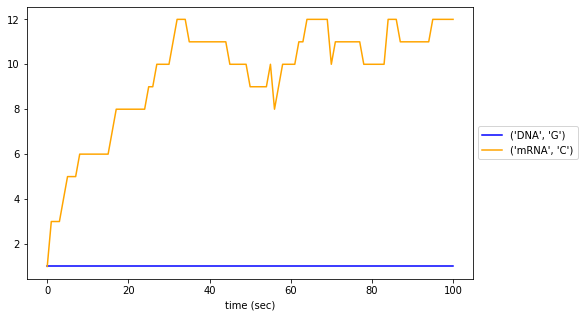

In [20]:
# make the transcription process
parameters = {
    'ktx': 1e0,
    'kdeg': 1e-1}
stochastic_tx = StochasticTranscription(parameters)

# simulate with helper function simulate_process_in_experiment
sim_settings = {
    'total_time': 100,
    'experiment_id': 'stochastic_tx'}
transcription_output = simulate_process_in_experiment(
    stochastic_tx, 
    sim_settings)

# plot output
plot_output(transcription_output)


# Swap Stochastic Transcription into TxTl Composite

This makes a new TxTl composite, with `StochasticTranscription` in place of the deterministic `Transcription` Process.

In [11]:
class StochasticTxTl(Composite):
    
    def generate_processes(self, config):
        return {
            'Tx': StochasticTranscription(),  # Tx Process is here changed to Stochastic
            'Tl': Translation()}

    def generate_topology(self, config):
        return {
            'Tx': {
                'DNA': ('DNA',),
                'mRNA': ('mRNA',),
            },
            'Tl': {
                'mRNA': ('mRNA',),
                'Protein': ('Protein',),
            },
        }
    

# Simulate Stochastic TxTl Composite


Experiment ID: stochastic_txtl
Created: 12/24/2020 at 15:48:32
Completed in 0.456153 seconds


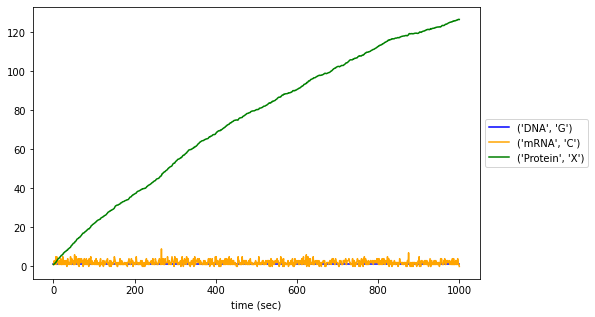

In [21]:
# initialize TxTl composite
tx_tl_composite = StochasticTxTl()

# make the experiment
exp_settings = {
    'total_time': 1000,
    'experiment_id': 'stochastic_txtl'}
tx_tl_experiment = compartment_in_experiment(tx_tl_composite, exp_settings)

# simulate and retrieve the data from emitter
tx_tl_experiment.update(1000)
tx_tl_data = tx_tl_experiment.emitter.get_timeseries()

# plot output
plot_output(tx_tl_data)


# Derivers
Derivers are a type of Process that runs after the dynamical process, and calculates some states from others -- for example, volume from mass and density.

In [28]:
# Deriver converts counts to mass
class GrowthDeriver(Deriver):
    defaults = {
        'molecular_weights': {
            'RNA': 1,
            'Protein': 100}}

    def ports_schema(self):
        return {
            'global': {
                'mass': {
                    '_default': 1.0,
                    '_updater': 'set',
                    '_emit': True}},
            'molecules': {
                'DNA': {'*': {}},
                'RNA': {'*': {}},
                'Protein': {'*': {}}}}
    
    def next_update(self, timestep, states):
        RNA = states['molecules']['RNA']
        Protein = states['molecules']['Protein']
        
        mass = 0.0
        for counts in RNA.values():
            mass += self.parameters['molecular_weights']['RNA'] * counts
        for counts in Protein.values():
            mass += self.parameters['molecular_weights']['Protein'] * counts
        
        return {
            'global': {
                'mass': mass}}

# Add Division

Here, a couple of Processes are imported from vivarium-core, and composed with the prior Processes.

In [29]:
from vivarium.processes.divide_condition import DivideCondition
from vivarium.processes.meta_division import MetaDivision

 
class GrowthDivision(Composite):
    
    defaults = {
        'agent_id': np.random.randint(0,100),
        'divide_condition': {
            'threshold': 1000},
        'agents_path': ('..', '..', 'agents',),
        'daughter_path': tuple()}
    
    def generate_processes(self, config):
        division_config = dict(
            daughter_path=config['daughter_path'], 
            agent_id=config['agent_id'], 
            generator=self)
        
        return {
            'Tx': StochasticTranscription(),
            'Tl': Translation(),
            'growth_deriver': GrowthDeriver({}),
            'divide_condition': DivideCondition(config['divide_condition']),
            'division': MetaDivision(division_config)}

    def generate_topology(self, config):
        return {
            'Tx': {
                'DNA': ('DNA',),
                'mRNA': ('RNA',)},
            'Tl': {
                'mRNA': ('RNA',),
                'Protein': ('Protein',)},
            'growth_deriver': {
                'global': ('boundary',),
                'molecules': {
                    'DNA': ('DNA',),
                    'RNA': ('RNA',),
                    'Protein': ('Protein',)}},
            'divide_condition': {
                'variable': ('boundary', 'mass',),
                'divide': ('boundary', 'divide',)},
            'division': {
                'global': ('boundary',),
                'agents': config['agents_path']}}
    

# Simulate TxTl with Division
This leads to many instances of TxTl simultaneously running in a single simulation

In [22]:
agent_id = '1'

# initialize GrowthDivision Composite
gd_config = {
    'agent_id': agent_id}
gd_composite = GrowthDivision(gd_config)

# make the experiment
initial_state = {
    'agents': {
        agent_id: {
            'DNA': {'G': 1},
            'RNA': {'C': 1},
            'Protein': {'X': 5}}}}
sim_settings = {
    'initial_state': initial_state,
    'outer_path': ('agents', agent_id),
    'experiment_id': 'division'}
gd_experiment = compartment_in_experiment(
    gd_composite, 
    sim_settings)

# simulate 
gd_experiment.update(200)



Experiment ID: division
Created: 12/24/2020 at 15:48:58
Completed in 4.04 seconds


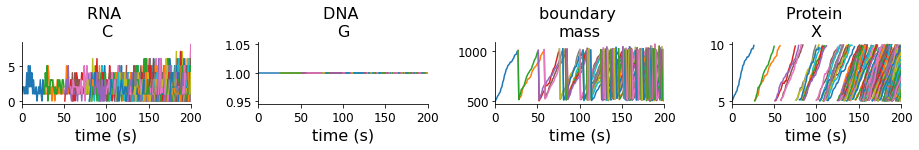

In [23]:
# retrieve the data
gd_data = gd_experiment.emitter.get_data()

# plot output
plot_settings = {}
fig = plot_agents_multigen(
    gd_data, 
    plot_settings)


# Put cells into a spatial environment

We here plug `GrowthDivision` into a spatial environmental process.

In [16]:
from vivarium_cell.processes.multibody_physics import Multibody

class Environment(Composite):
    
    defaults = {
        'bounds': [10, 10],
        '_schema': {
            'multibody': {
                'agents': {
                    '*': {
                        'boundary': {
                            'mass': {
                                '_default': 1.0},
                             'length': {
                                '_divider': 'set'}}}}}}}
    
    def generate_processes(self, config):
        return {
            'multibody': Multibody({'bounds': config['bounds']})}

    def generate_topology(self, config):
        return {
            'multibody': {
                'agents': ('agents',)}}
    

In [24]:
agent_id = '1'
lattice_bounds = [20, 20]
gd_config = {'agent_id': agent_id}
env_config = {'bounds': lattice_bounds}

# declare the hierarchy
hierarchy = {
    GENERATORS_KEY: {
        'type': Environment,
        'config': env_config},
    'agents': {
        agent_id: {
            GENERATORS_KEY: {
                'type': GrowthDivision,
                'config': gd_config}}}}

# configure experiment with helper function compose_experiment
experiment_settings = {
    'experiment_id': 'spatial_env'}
experiment = compose_experiment(
    hierarchy=hierarchy, 
    settings=experiment_settings)

# run the experiment
experiment.update(200)
env_output = experiment.emitter.get_data()



Experiment ID: spatial_env
Created: 12/24/2020 at 15:49:22
Completed in 2.52 seconds


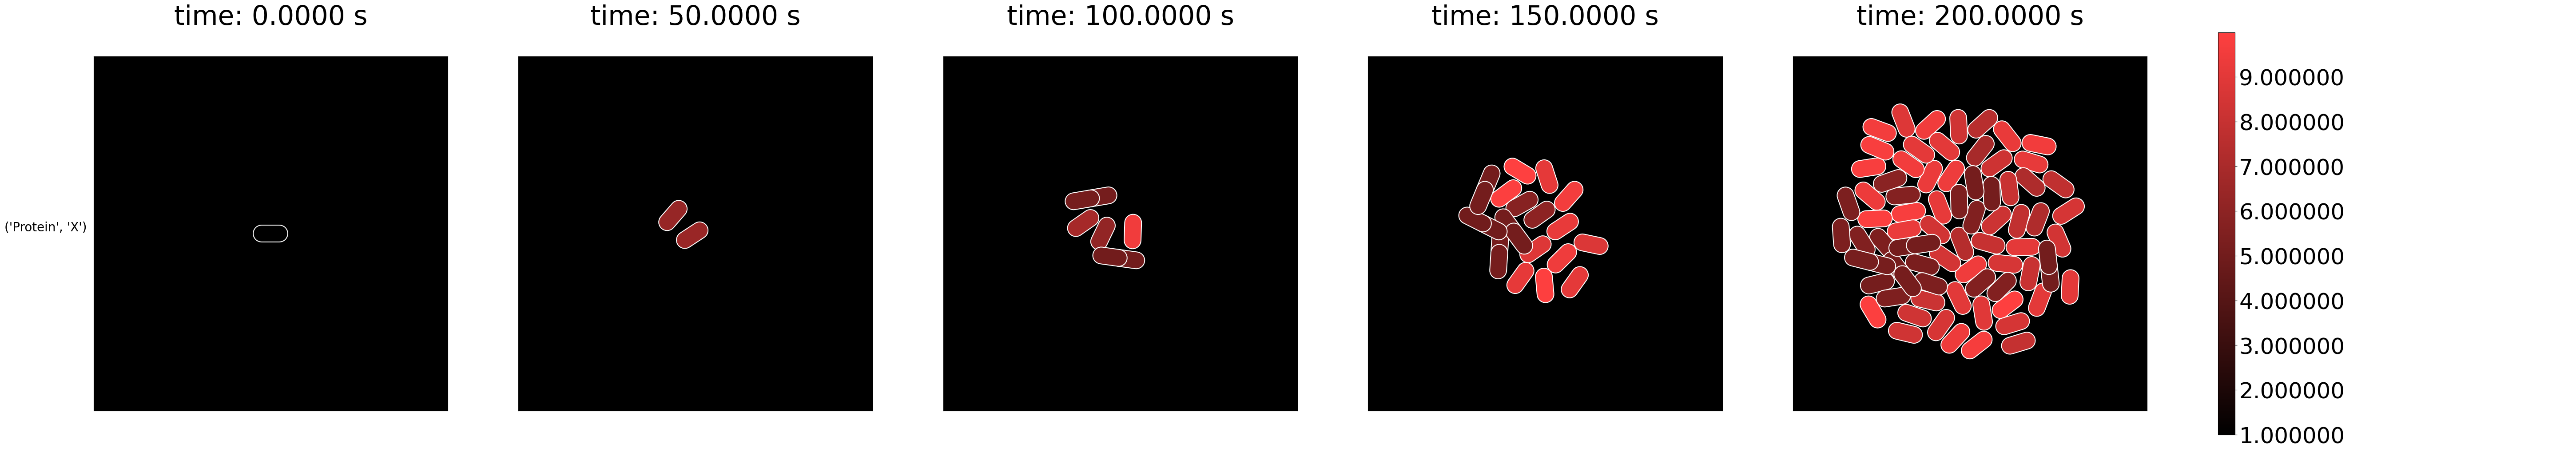

In [26]:
from vivarium_cell.plots.multibody_physics import plot_tags

# extract data
agents = {time: time_data['agents'] for time, time_data in env_output.items()}
plot_data = {
    'agents': agents,
    'config': {
        'bounds': lattice_bounds}}

# tags plot
tags_plot_settings = {
    'n_snapshots': 5,
    'convert_to_concs': False,
    'tagged_molecules': [('Protein', 'X',)]}
fig2 = plot_tags(
    plot_data, 
    tags_plot_settings)
